In [1]:
using Pkg
Pkg.activate("../../Project.toml")

include("../../LogLoss/RealRealHighDimension.jl")
include("../ForecastingMainNew.jl");
using JLD2
using DataFrames
using StatProfilerHTML
using BenchmarkTools

  Activating project at `~/Documents/QML Project/QuantumInspiredML`


In [2]:
svpath_sl = "../../Data/ecg200/mps_saves/sahand_legendre_ns_d20_chi100.jld2" #legendre_no_norm_ns_d16_chi60.jld2" #legendreNN2_ns_d8_chi35.jld2"
svpath_leg = "../../Data/ecg200/mps_saves/legendre_no_norm10_ns_d20_chi100.jld2" #legendre_no_norm_ns_d16_chi60.jld2" #legendreNN2_ns_d8_chi35.jld2"

dloc =  "../../Data/ecg200/datasets/ecg200.jld2"



f = jldopen(dloc, "r")
    X_train = read(f, "X_train")
    y_train = read(f, "y_train")
    X_test = read(f, "X_test")
    y_test = read(f, "y_test")
close(f)



###################################3

f = jldopen(svpath_sl, "r")
    mps_sl = read(f, "mps")
    opts_sl = read(f, "opts")
close(f)

opts_sl, _... = safe_options(opts_sl, nothing, nothing)

fc_sl = load_forecasting_info_variables(mps_sl, X_train, y_train, X_test, y_test, opts_sl);


#########################################
f = jldopen(svpath_leg, "r")
    mps_leg = read(f, "mps")
    opts_leg = read(f, "opts")
close(f)

opts_leg, _... = safe_options(opts_leg, nothing, nothing)

fc_leg = load_forecasting_info_variables(mps_leg, X_train, y_train, X_test, y_test, opts_leg);



++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
                         Summary:

 - Dataset has 100 training samples and 100 testing samples.
 - 2 class(es) was detected. Slicing MPS into individual states...
 - Time independent encoding - Sahand-Legendre Time Independent - detected.
 - d = 20, chi_max = 100
Re-encoding the training data to get the encoding arguments...

 Created 2 forecastable struct(s) containing class-wise mps and test samples.
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
                         Summary:

 - Dataset has 100 training samples and 100 testing samples.
 - 2 class(es) was detected. Slicing MPS into individual states...
 - Time independent encoding - Legendre_No_Norm - detected.
 - d = 20, chi_max = 100

 Created 2 forecastable struct(s) containing class-wise mps and test samples.


In [3]:
svpath = "ecg200/Median_d20chi100_sites6:21.jld2"
f = jldopen(svpath, "r")
    sl_stats = f["sl_stats"]
    leg_stats = f["leg_stats"]
close(f)

In [4]:
stats_leg = vcat(DataFrame.(leg_stats)...)
stats_sl = vcat(DataFrame.(sl_stats)...)

describe(stats_leg) |> display

describe(stats_sl) |> display

bad_order = sortperm(stats_sl[!,1]) |> reverse
bad = zip(bad_order, stats_sl[!,1][bad_order])  |> collect 

Row,variable,mean,min,median,max,nmissing,eltype
,Symbol,Float64,Float64,Float64,Float64,Int64,DataType
1,MAE,0.440189,0.0936716,0.326884,2.45373,0,Float64
2,NN_MAE,0.348285,0.115119,0.281254,1.53579,0,Float64


Row,variable,mean,min,median,max,nmissing,eltype
,Symbol,Float64,Float64,Float64,Float64,Int64,DataType
1,MAE,0.440189,0.0936716,0.326884,2.45373,0,Float64
2,NN_MAE,0.348285,0.115119,0.281254,1.53579,0,Float64


100-element Vector{Tuple{Int64, Float64}}:
 (8, 2.453731235520313)
 (24, 2.2686214787984382)
 (13, 2.2452668819906254)
 (34, 1.7730014028593748)
 (4, 1.6279644870999999)
 (16, 0.9719290566828127)
 (6, 0.810176677242187)
 (53, 0.689012140753125)
 (58, 0.6642299087171878)
 (25, 0.641093895609375)
 ⋮
 (9, 0.1556489120187498)
 (14, 0.14906829451249973)
 (55, 0.1377341711593749)
 (62, 0.13581789295468755)
 (50, 0.13400027566406245)
 (69, 0.13104436610156273)
 (40, 0.12880169599218766)
 (56, 0.09683898757031242)
 (57, 0.0936716288703126)

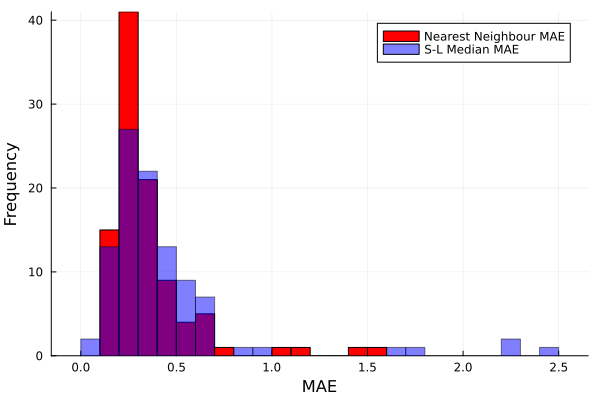

In [5]:

histogram(stats_sl[!, :NN_MAE], label="Nearest Neighbour MAE", colour=:red)#, bins=bins)

h2 = histogram!(stats_sl[!, :MAE], label="S-L Median MAE", colour=:blue, alpha=0.5)#, bins=bins)
xlabel!("MAE")
ylabel!("Frequency")

In [9]:
include("../ForecastingMainNew.jl");

dx=1E-4
mode_range=(-1,1)
xvals=collect(range(mode_range...; step=dx))
mode_index=Index(opts_sl.d)
xvals_enc= [get_state(x, opts_sl, fc_sl[1].enc_args) for x in xvals]
xvals_enc_it=[ITensor(s, mode_index) for s in xvals_enc];

  6.585569 seconds (20.95 M allocations: 3.947 GiB, 12.20% gc time, 36.86% compilation time)
╭────────┬─────────╮
│ Metric │   Value │
├────────┼─────────┤
│    MAE │ 1.73574 │
│ NN_MAE │ 1.41131 │
╰────────┴─────────╯


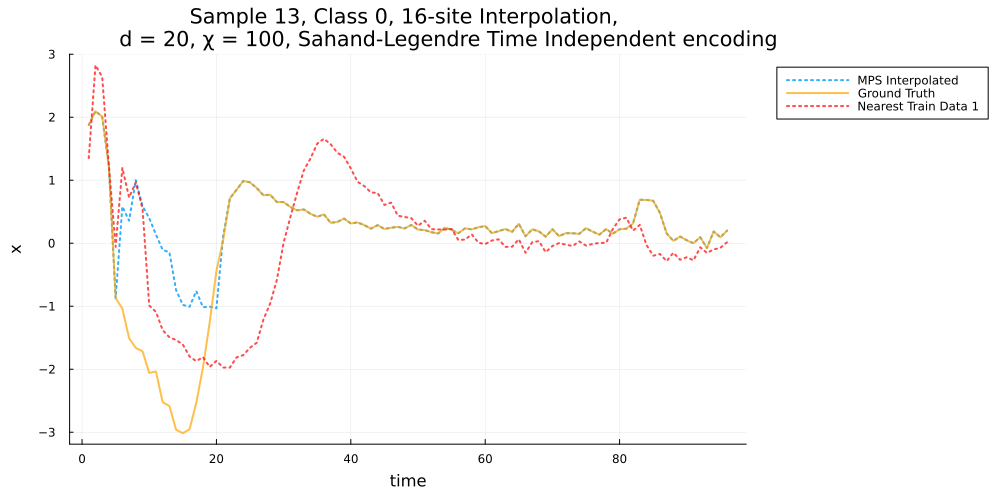

In [10]:
max_jump=0.5
class = 0
interp_sites = collect(6:21)
instance_idx = 13 # 4
invert_transform=true
@time begin 
stats, p1_ns = any_interpolate_single_timeseries(fc_sl, class, instance_idx, interp_sites, :directMedian; invert_transform=invert_transform, NN_baseline=true, X_train=X_train, y_train=y_train, n_baselines=1, plot_fits=true, dx=dx, mode_range=mode_range, xvals=xvals, mode_index=mode_index, xvals_enc=xvals_enc, xvals_enc_it=xvals_enc_it, max_jump=max_jump);
end

pretty_table(stats; header=["Metric", "Value"], header_crayon= crayon"yellow bold", tf = tf_unicode_rounded);
plot(p1_ns...)


┌ Warning: Test set has a value more than 1% below lower bound after train normalization!
└ @ Main /home/noodles/Documents/QML Project/QuantumInspiredML/Interpolation/ForecastingMainNew.jl:769


  4.116510 seconds (18.45 M allocations: 3.921 GiB, 9.48% gc time)
╭────────┬─────────╮
│ Metric │   Value │
├────────┼─────────┤
│    MAE │ 2.24527 │
│ NN_MAE │ 1.41131 │
╰────────┴─────────╯


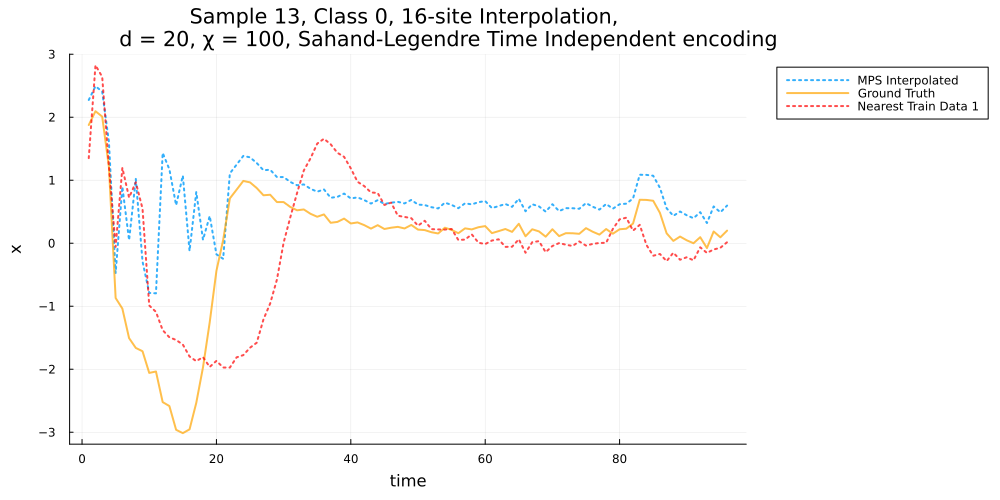

In [25]:
max_jump=0.5
class = 0
interp_sites = collect(6:21)
instance_idx = 13 # 4
invert_transform=true
@time begin 
stats, p1_ns = any_interpolate_single_timeseries(fc_sl, class, instance_idx, interp_sites, :directMedian; invert_transform=invert_transform, NN_baseline=true, X_train=X_train, y_train=y_train, n_baselines=1, plot_fits=true, dx=dx, mode_range=mode_range, xvals=xvals, mode_index=mode_index, xvals_enc=xvals_enc, xvals_enc_it=xvals_enc_it, max_jump=max_jump);
end

pretty_table(stats; header=["Metric", "Value"], header_crayon= crayon"yellow bold", tf = tf_unicode_rounded);
plot(p1_ns...)
